<a href="https://colab.research.google.com/github/camigutie/DS4002-Project1/blob/main/SCRIPTS/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !git clone https://github.com/camigutie/DS4002-Project1.git

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy.stats import ttest_ind

In [3]:
df = pd.read_parquet('../DATA/email.parquet')

In [4]:
# Split data into features and target
X = df.drop(columns=['email_type'])
y = df['email_type']

In [5]:
# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [6]:
# Train the logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [7]:
# Predict on the test set and calculate accuracy
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

In [8]:
# T-test to evaluate statistical significance of sentiment score between phishing and safe emails
phishing_scores = df[df['email_type'] == 1]['compound']
safe_scores = df[df['email_type'] == 0]['compound']
t_stat, p_value = ttest_ind(phishing_scores, safe_scores, equal_var=False)

In [9]:
# Compile results
results = {
    'Model Accuracy': f"{accuracy:.2%}",
    'T-Test Statistic': float(t_stat),
    'P-Value': float(p_value),
    'Significant (p < 0.05)': bool(p_value < 0.05)
}

results

{'Model Accuracy': '96.38%',
 'T-Test Statistic': 9.595926964182647,
 'P-Value': 9.533187930925757e-22,
 'Significant (p < 0.05)': True}

In [10]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97      2254
           1       0.95      0.96      0.95      1473

    accuracy                           0.96      3727
   macro avg       0.96      0.96      0.96      3727
weighted avg       0.96      0.96      0.96      3727



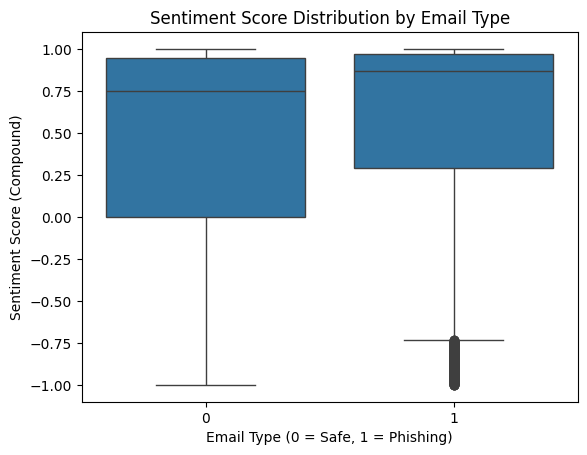

<Figure size 640x480 with 0 Axes>

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=df["email_type"], y=df["compound"])
plt.xlabel("Email Type (0 = Safe, 1 = Phishing)")
plt.ylabel("Sentiment Score (Compound)")
plt.title("Sentiment Score Distribution by Email Type")
plt.show()
plt.savefig("../OUTPUT/sentiment_distribution.png")

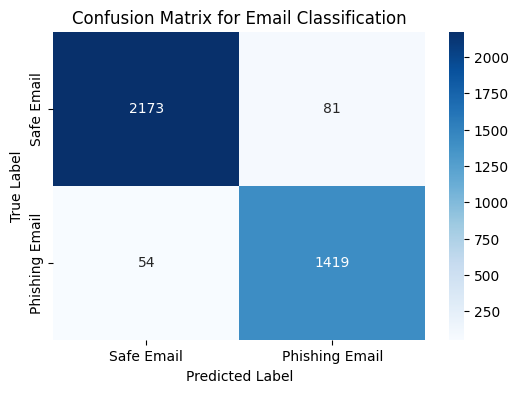

<Figure size 640x480 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define class labels
labels = ["Safe Email", "Phishing Email"]

# Create heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Titles and labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Email Classification")
plt.show()
plt.savefig("../OUTPUT/confusion_matrix.png")

In [13]:
feature_names = df.columns
coef = log_reg.coef_[0]

top_positive = np.argsort(coef)[-10:]  # Top 10 phishing indicators
top_negative = np.argsort(coef)[:10]  # Top 10 safe indicators

print("Top Phishing Words:", [feature_names[i] for i in top_positive])
print("Top Safe Words:", [feature_names[i] for i in top_negative])

Top Phishing Words: ['sie', 'spamassassin devel', '2003', 'fred', 'sitara', 'monday', 'em', 'removal', '2004', 'clearly']
Top Safe Words: ['enquiries', 'thank', '2001 dow', 'wrong', 'lang', 'universities', 'assurance', 'vii', 'urgent', 'eds']


In [ ]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Features")
plt.show()